In [1]:
#lines for google colab
#!pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f https://data.pyg.org/whl/torch-1.10.0+cu111.html
#!pip install forgi
#!tar -xf data.tar.xz
import os
import datetime
import numpy as np
import torch as th
import torch_geometric.transforms as T
from torch_geometric.loader import DenseDataLoader, DataLoader
import torch.nn.functional as F
import matplotlib.pyplot as plt
from classifier.data import CGDataset
from classifier.model import Diff_CG_Classifier, MinCut_CG_Classifier, DMoN_CG_Classifier
from classifier.train import pool_train_loop
from classifier.test import pool_test_loop

print("Pytorch Version", th.__version__)
print("Cuda is available:", th.cuda.is_available())

device = th.device("cuda" if th.cuda.is_available() else "cpu")
print("Using device:", device)

vectorize = True
k = 0

#Training Set
training_dir = "data/train_set"
rmsd_list = "data/truncated_train_rmsd.txt" #"data/train_rmsd_list.txt" #
training_dataset = CGDataset(training_dir, rmsd_list, vectorize, k)#, transform=T.ToDense(64))

#Validation Set
val_dir = "data/val_set"
val_rmsd = "data/val_rmsd_list.txt"
val_dataset = CGDataset(val_dir, val_rmsd, vectorize, k)#, transform=T.ToDense(64))

#Test Data
test_dir = "data/test_set"
test_rmsd = "data/test_rmsd_list.txt"
test_dataset = CGDataset(test_dir, test_rmsd, vectorize, k)#, transform=T.ToDense(64))

#5S rRNA and tRNA Test Data (previous training data)
st_test_dir = "data/old_training_set"
st_test_rmsd = "data/old_train_rmsd_list.txt"
st_test_dataset = CGDataset(st_test_dir, st_test_rmsd, vectorize, k)#, transform=T.ToDense(64))

#Rotated Test Sets
test_dir_rot = "data/test_set_rot"
test_rmsd = "data/test_rmsd_list.txt"
rot_test_dataset = CGDataset(test_dir_rot, test_rmsd, vectorize, k)#, transform=T.ToDense(64))

fst_test_rot = "data/5st_test_rot"
fst_rot_dataset = CGDataset(fst_test_rot, st_test_rmsd, vectorize, k)#, transform=T.ToDense(64))

Pytorch Version 1.11.0
Cuda is available: True
Using device: cuda


TODO:
*  **Check why fewer graphs are loaded into the training dataset than are in the rmsd list** --> change from InMemoryDataset to Dataset **DONE**  --> duplicates in train rmsd list leads to discrepancy
*  Add further that start of s1 is in yz-plane with s0 **Semi-DONE** (theres still a range of angles)
*  are there additional tertiary interactions detected to add?
*  softplus or relu for last classification step? if any non-linearity that ensures that no negative results are returned?
*  try skip-cat/-sum in layer architecture

08.06.2022 11:44:38 Creating Training Directory at 2022-06-08_11-44_MinCut_CG_Classifier/
08.06.2022 11:44:42 Loading Datasets
08.06.2022 11:44:42 Start Training


Epoch 0: Training loss 11.9642; Validation loss 14.7172, MAE: 14.9689; lr: 0.00100
	Add. Loss: Training 0.2505, Validation 0.2382
Epoch 5: Training loss 4.5576; Validation loss 15.5412, MAE: 15.7940; lr: 0.00100
	Add. Loss: Training 0.2437, Validation 0.2405
Epoch 10: Training loss 3.7198; Validation loss 14.6228, MAE: 14.8820; lr: 0.00100
	Add. Loss: Training 0.2432, Validation 0.2316
Epoch 15: Training loss 2.9592; Validation loss 14.9765, MAE: 15.2194; lr: 0.00100
	Add. Loss: Training 0.2429, Validation 0.2434
Epoch 20: Training loss 2.6593; Validation loss 14.5339, MAE: 14.7819; lr: 0.00100
	Add. Loss: Training 0.2488, Validation 0.2388
Epoch 25: Training loss 2.2941; Validation loss 14.3429, MAE: 14.5869; lr: 0.00100
	Add. Loss: Training 0.2487, Validation 0.2394
Epoch 30: Training loss 2.2628; Validation loss 14.3808, MAE: 14.6227; lr: 0.00100
	Add. Loss: Training 0.2505, Validation 0.2479
Epoch 35: Training loss 2.0304; Validation loss 13.8654, MAE: 14.1207; lr: 0.00100
	Add. Lo

08.06.2022 12:14:32 Training took 0.50 hours
08.06.2022 12:14:32 Minimum Training Loss -0.7793 in epoch 3792
08.06.2022 12:14:32 Minimum Validation Loss (after 0 epochs) 11.7170 in epoch 3695
08.06.2022 12:14:32 Minimum MAE (after 0 epochs) 12.7237 in epoch 2217
08.06.2022 12:14:32 Seed used for training was: 10807973141991311177


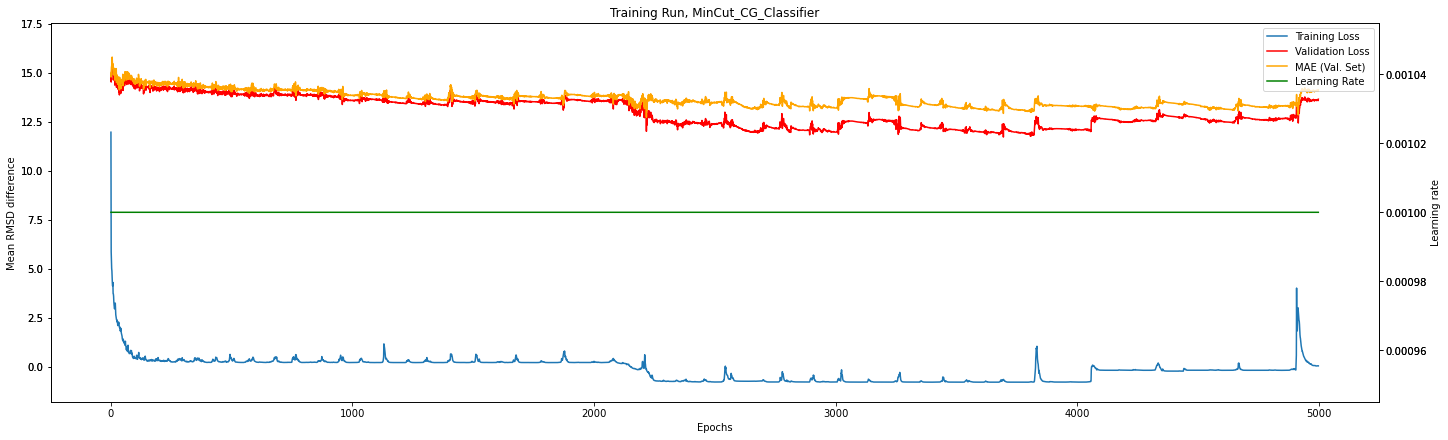

In [2]:
#Training
model = MinCut_CG_Classifier(training_dataset.num_node_features)

parent_dir = "run_data/"


#epoch_losses, val_losses, mae_losses, learning_rates, epoch_add_losses = 
#with th.autograd.detect_anomaly():
pool_train_loop(
    model=model,
    train_dataset=training_dataset,
    val_dataset=val_dataset,
    model_dir=parent_dir,
    device=device,
    b_size=64,
    lr=1e-3,
    epochs=5_000,
    sched_T0=0,
    vectorize=vectorize,
    k=k,
    #resume="run_data/2022-05-17_12-18_MinCut_CG_Classifier/model_data/epoch_4516.pth",
    burn_in=0)

In [3]:
#get training run data

run_dir = "run_data/2022-06-08_11-44_MinCut_CG_Classifier"
burn_in = 50

file_lines = []
with open(run_dir + "/loss_data.txt", "r") as fh:
    for line in fh.readlines():
        file_lines.append(line.rstrip("]\n").lstrip("[").split(","))

epoch_losses = [float(a) for a in file_lines[0]]
val_losses = [float(b) for b in file_lines[1]]
learning_rates = [float(c) for c in file_lines[2]]
mae_losses = [float(d) for d in file_lines[3]]
epoch_add_losses = [float(d) for d in file_lines[4]]

print(f"Minimum Training Loss {min(epoch_losses):.4f} in epoch {epoch_losses.index(min(epoch_losses))}")
print(f"Minimum Validation Loss (after {burn_in} epochs) {min(val_losses[burn_in:]):.4f} in epoch {val_losses.index(min(val_losses[burn_in:]))}")
print(f"Minimum MAE (after {burn_in} epochs) {min(mae_losses[burn_in:]):.4f} in epoch {mae_losses.index(min(mae_losses[burn_in:]))}")


Minimum Training Loss -0.7793 in epoch 3792
Minimum Validation Loss (after 50 epochs) 11.7170 in epoch 3695
Minimum MAE (after 50 epochs) 12.7237 in epoch 2217


Validation Loss at 2263 is 12.4517
5 before select
12.5542, 12.6197, 12.5211, 12.5169, 12.5132
5 after select
12.5555, 12.5327, 12.5255, 12.5169, 12.5409
MAE at 2263 is 13.4867


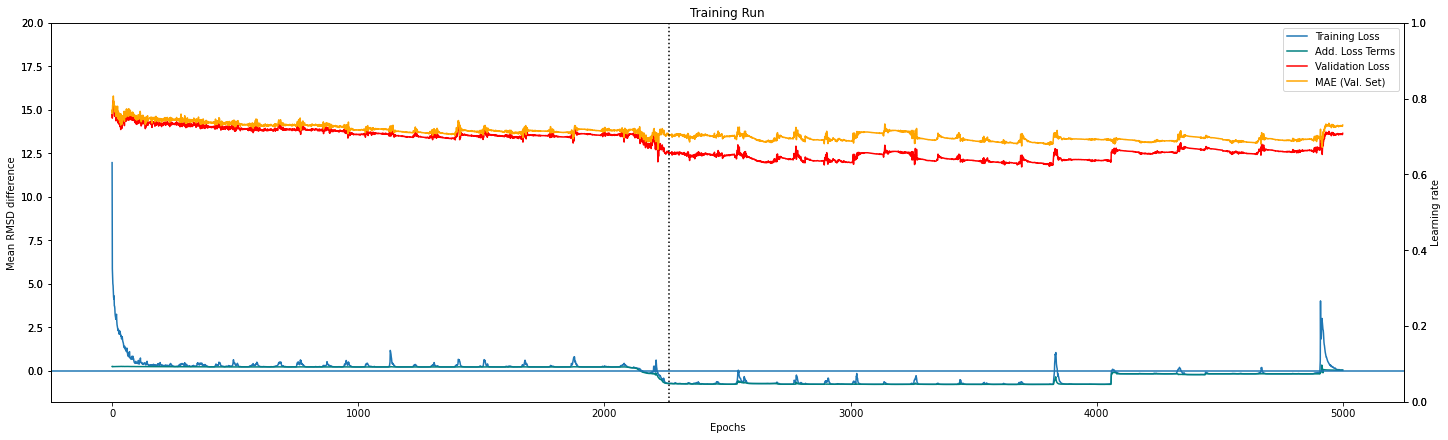

In [11]:
#plot the training run
select = 2263

print(f"Validation Loss at {select} is {val_losses[select]:.4f}")
print("5 before select")
print((", ").join([f"{x:.4f}" for x in val_losses[select-5:select]]))
print("5 after select")
print((", ").join([f"{y:.4f}" for y in val_losses[select+1:select+6]]))
print(f"MAE at {select} is {mae_losses[select]:.4f}")

fig, ax1 = plt.subplots(layout="constrained", figsize=(20, 6))
ax1.secondary_yaxis("left")
ax1.plot(epoch_losses, label="Training Loss")
ax1.plot(epoch_add_losses, "teal", label="Add. Loss Terms")
ax1.plot(val_losses, "r", label="Validation Loss")
ax1.plot(mae_losses, "orange", label="MAE (Val. Set)")

ax2 = ax1.twinx()
ax2.secondary_yaxis("right")
#ax2.plot(learning_rates, "g", label="Learning Rate")
plt.title("Training Run")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Mean RMSD difference")
ax2.set_ylabel("Learning rate")

ax1.set_ybound(lower=(min(epoch_losses)-1), upper=20)#max(val_losses)+2)
plt.axvline(x = select, c = "black", ls = ':')
ax1.axhline(y=0)

han1, lab1 = ax1.get_legend_handles_labels()
han2, lab2 = ax2.get_legend_handles_labels()
plt.legend(han1 + han2, lab1 + lab2, loc="upper right")
plt.draw()

Using state dict from epoch 2263
Test Set
Minimum Loss: Label = 25.5360, Prediction = 25.5190, Loss = 0.0001
Maximum Loss: Label = 41.4410, Prediction = 16.7920, Loss = 24.1490
Mean Test loss: 	 10.8680
Std. Dev. of Test loss:  6.9599
Min loss: 		 0.0001
First Quantile: 	 4.7873
Median: 		 9.8681
Third Quantile: 	 17.6294
Max Loss: 		 24.1490
LinregressResult(slope=0.2592497749893538, intercept=11.852899477822586, rvalue=0.10852869832586579, pvalue=0.07131915722709675, stderr=0.1431972246686534, intercept_stderr=2.84275685286812)


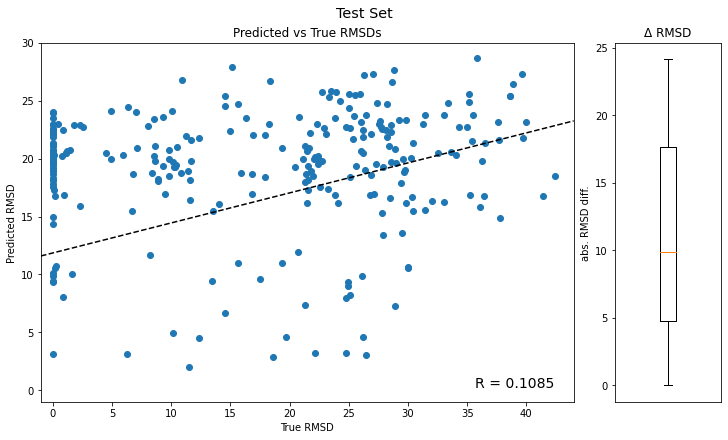

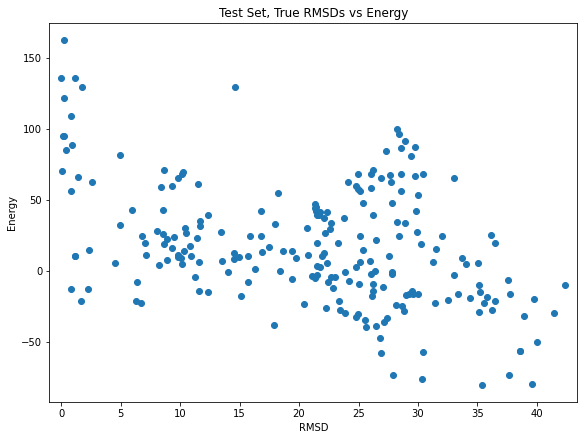

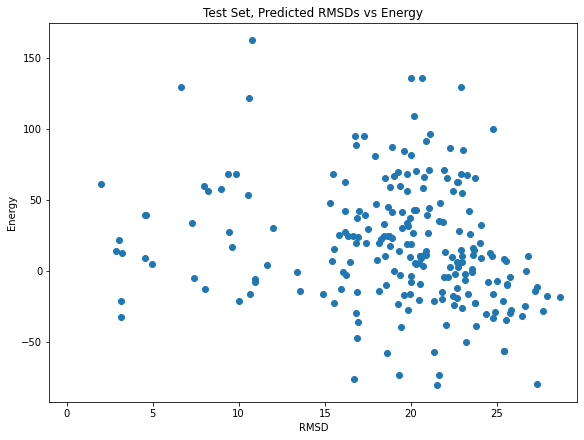

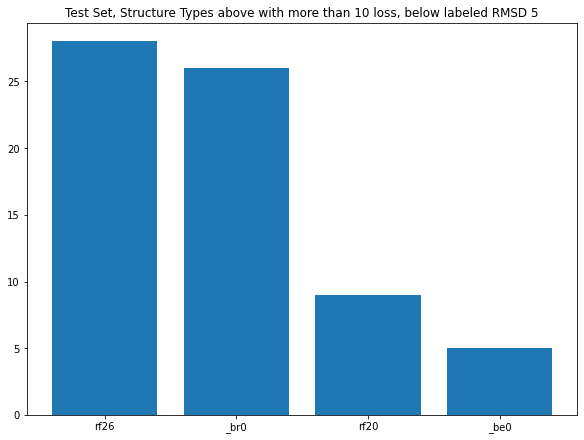

5S and tRNA Test Set
Minimum Loss: Label = 19.0030, Prediction = 18.9969, Loss = 0.0000
Maximum Loss: Label = 0.0000, Prediction = 26.2489, Loss = 25.7489
Mean Test loss: 	 3.8900
Std. Dev. of Test loss:  4.4059
Min loss: 		 0.0000
First Quantile: 	 0.8972
Median: 		 2.4346
Third Quantile: 	 5.2031
Max Loss: 		 25.7489
LinregressResult(slope=0.9416194305024929, intercept=-0.614483675201873, rvalue=0.7417816194276883, pvalue=8.922291235235993e-190, stderr=0.025892675293965356, intercept_stderr=0.489084873695395)


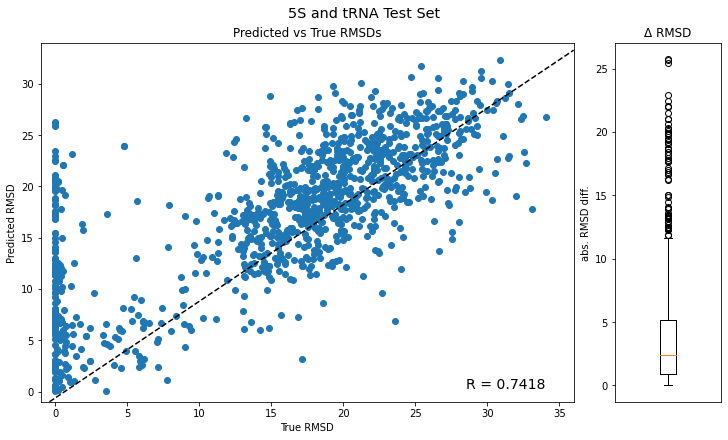

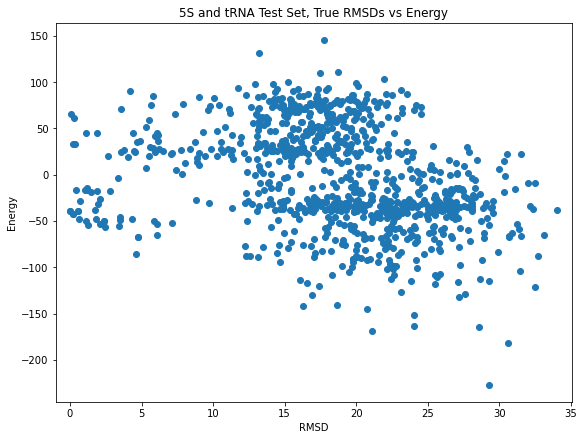

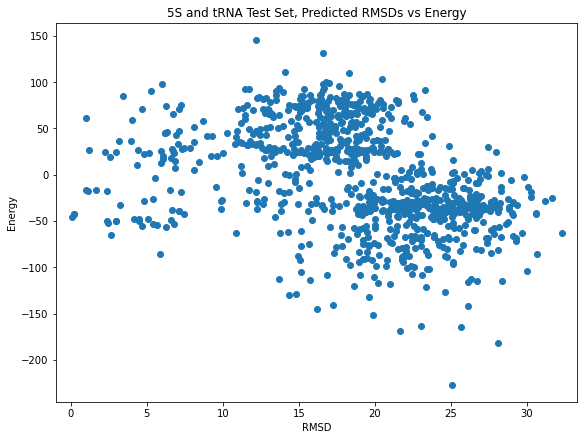

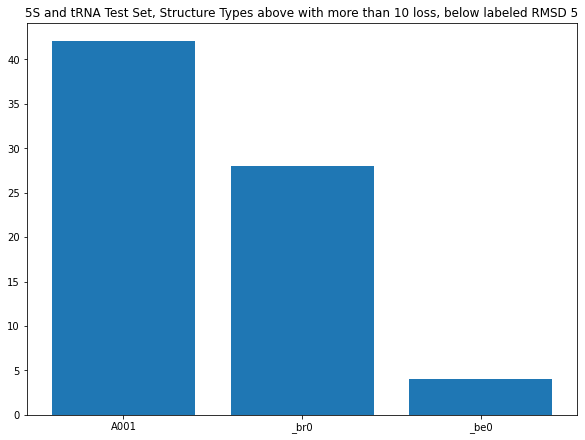

Prediction below 0: Label 0.0330, Pred -0.0676
Prediction below 0: Label 0.0340, Pred -0.0670
Training Set
Minimum Loss: Label = 4.4380, Prediction = 4.4380, Loss = 0.0000
Maximum Loss: Label = 30.4960, Prediction = 29.7106, Loss = 0.3084
Mean Test loss: 	 0.0098
Std. Dev. of Test loss:  0.0223
Min loss: 		 0.0000
First Quantile: 	 0.0005
Median: 		 0.0024
Third Quantile: 	 0.0093
Max Loss: 		 0.3084
LinregressResult(slope=0.9962269187487764, intercept=0.02722445427366793, rvalue=0.999900126700779, pvalue=0.0, stderr=0.0005114414215371639, intercept_stderr=0.010314202922884418)


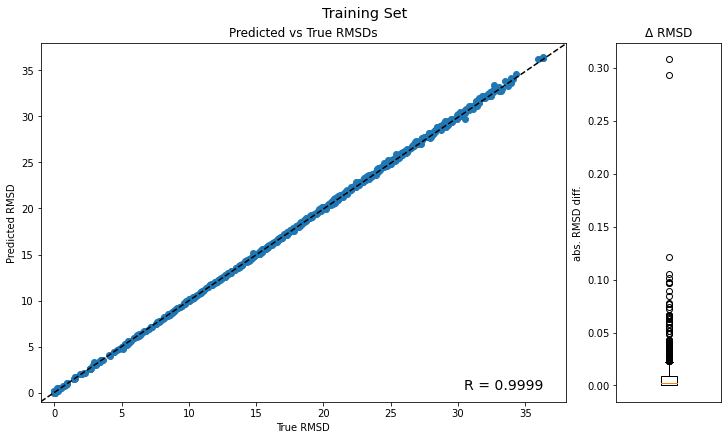

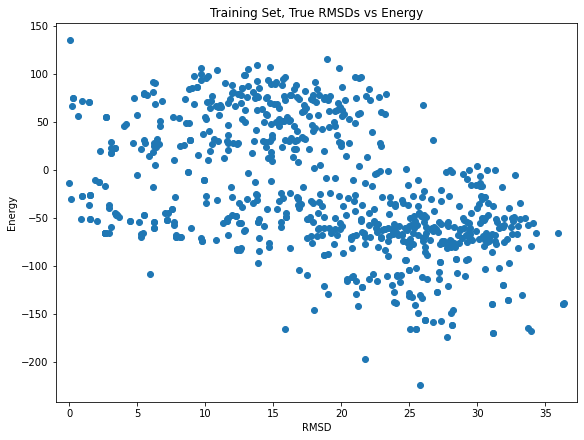

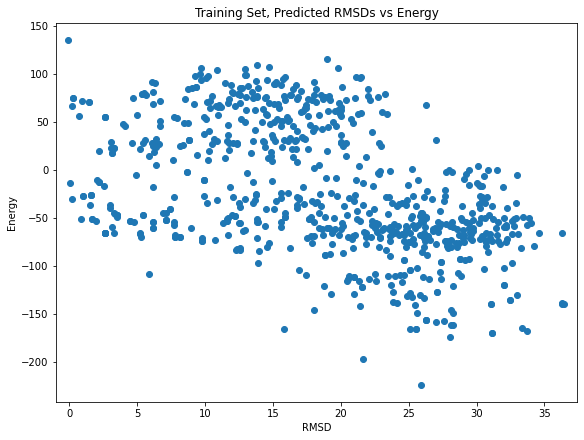

Validation Set
Minimum Loss: Label = 17.4220, Prediction = 17.4024, Loss = 0.0002
Maximum Loss: Label = 61.9850, Prediction = 19.6512, Loss = 41.8338
Mean Test loss: 	 12.7860
Std. Dev. of Test loss:  9.2716
Min loss: 		 0.0002
First Quantile: 	 4.1712
Median: 		 12.2015
Third Quantile: 	 19.5614
Max Loss: 		 41.8338
LinregressResult(slope=0.5115691300941583, intercept=12.569669986318418, rvalue=0.1509815959286735, pvalue=0.002592899584281987, stderr=0.16874268259000014, intercept_stderr=3.6108646575489205)


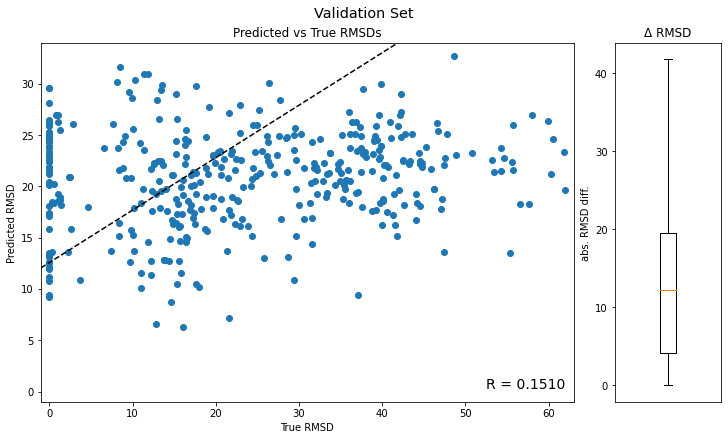

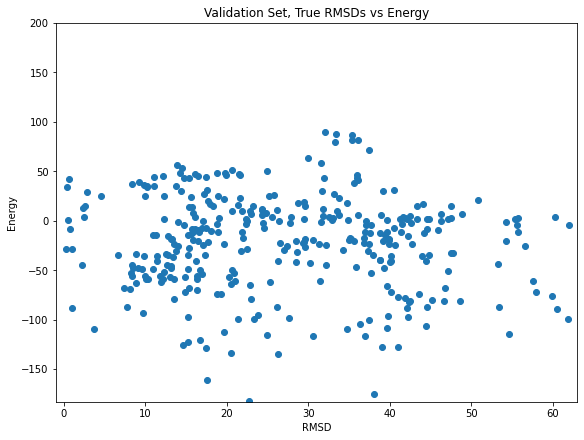

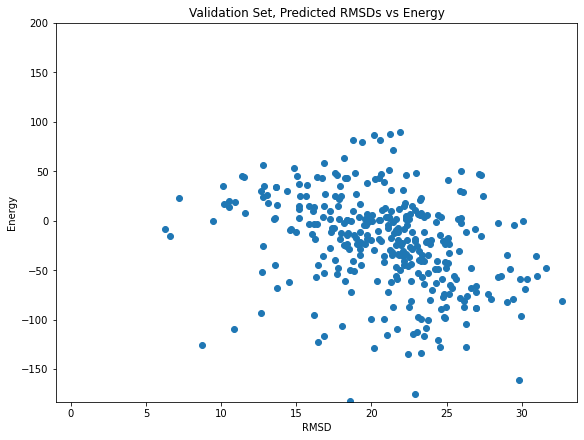

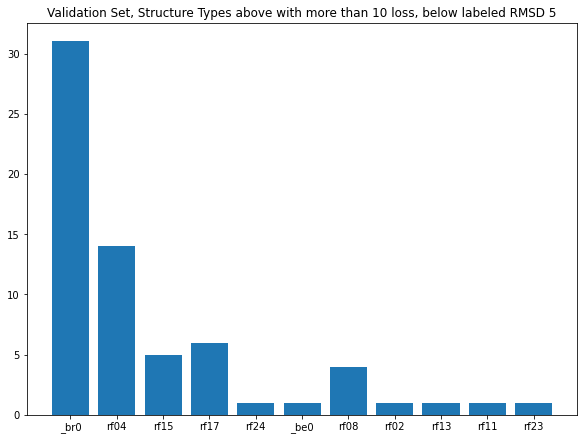

LinregressResult(slope=0.7517825350539507, intercept=6.25325723631342, rvalue=0.43426315436815177, pvalue=1.2825196420243257e-69, stderr=0.04041229865933591, intercept_stderr=0.8177639130970258)


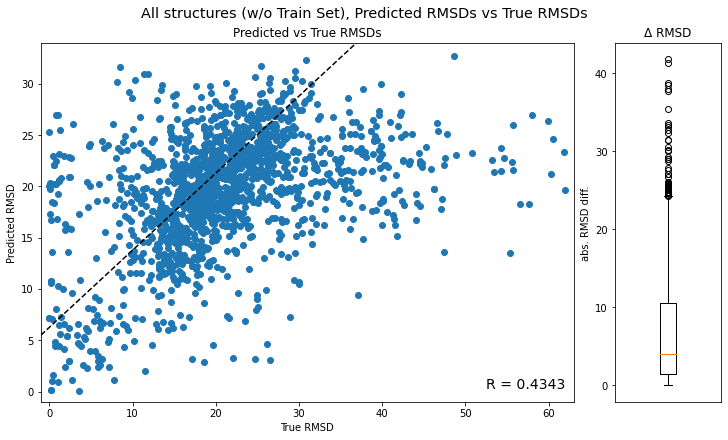

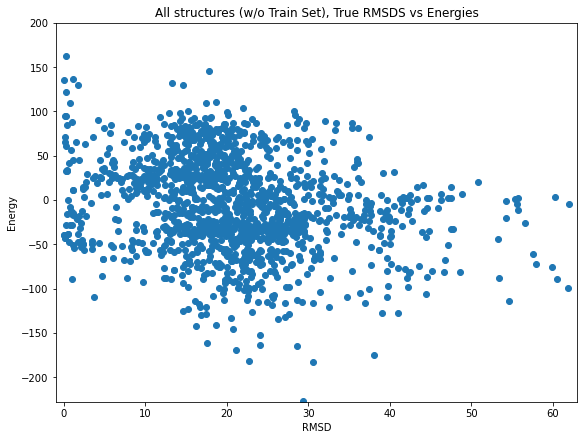

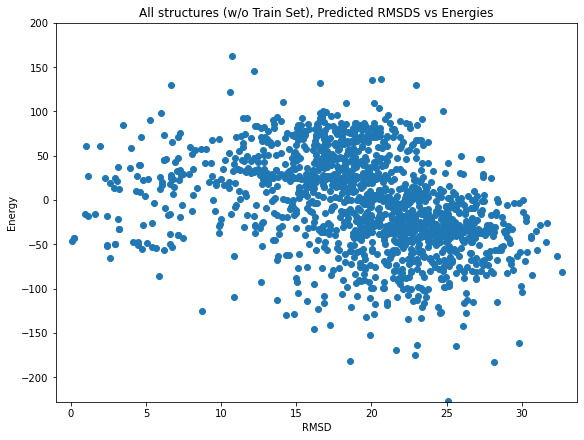

In [12]:
#Test
from classifier.utility import get_energy_dict, rmsd_scatter, e_rmsd_scatter

# loss cutoff for type histo
cutoff = [10, 5]

if "model" not in globals():
    print("Model not in global variables")
    model = DMoN_CG_Classifier(training_dataset.num_node_features).to(device)

train_loader = DataLoader(training_dataset, batch_size=1)
val_loader = DataLoader(val_dataset, batch_size=1)
test_dataloader = DataLoader(test_dataset, batch_size=1)
st_test_dataloader = DataLoader(st_test_dataset, batch_size=1)

model.to(device)
checkpoint = th.load(f"{run_dir}/model_data/epoch_{select}.pth")
print(f"Using state dict from epoch {checkpoint['epoch']}")
model.load_state_dict(checkpoint["model_state_dict"])

energy_l = []
true_rmsd_l = []
pred_rmsd_l = []
test_ls = []
for loader in [test_dataloader, st_test_dataloader, train_loader, val_loader]:
    if loader == test_dataloader:
        title = "Test Set"
        e_dict = get_energy_dict("data/test_energy.txt")
    elif loader == st_test_dataloader:
        title = "5S and tRNA Test Set"
        e_dict = get_energy_dict("data/old_train_energy.txt")
    elif loader == train_loader:
        title = "Training Set"
        e_dict = get_energy_dict("data/train_energy.txt")
    elif loader == val_loader:
        title = "Validation Set"
        e_dict = get_energy_dict("data/val_energy.txt")
    en, trs, prs, tlosses = pool_test_loop(model, loader, e_dict, title, device, cutoff)
    if loader != train_loader:
        energy_l += en
        true_rmsd_l += trs
        pred_rmsd_l += prs
        test_ls += tlosses

        

rmsd_scatter(pred_rmsd_l, true_rmsd_l, test_ls, "All structures (w/o Train Set), Predicted RMSDs vs True RMSDs")
e_rmsd_scatter(energy_l, true_rmsd_l, "All structures (w/o Train Set), True RMSDS vs Energies")
e_rmsd_scatter(energy_l, pred_rmsd_l, "All structures (w/o Train Set), Predicted RMSDS vs Energies")

LinregressResult(slope=1.0028041508005343, intercept=-0.1448622544717857, rvalue=0.9786537215235469, pvalue=5.294515226000338e-191, stderr=0.012698917670314832, intercept_stderr=0.25745681513290664)


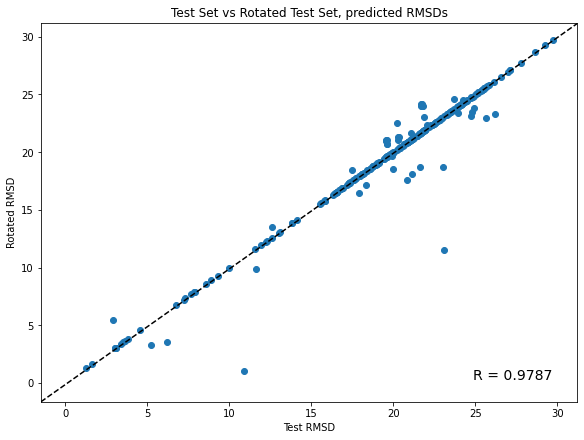

LinregressResult(slope=0.9887371526233785, intercept=0.03497527450104698, rvalue=0.9880382636716976, pvalue=2.613211198827996e-225, stderr=0.009305725225059349, intercept_stderr=0.124566404156903)


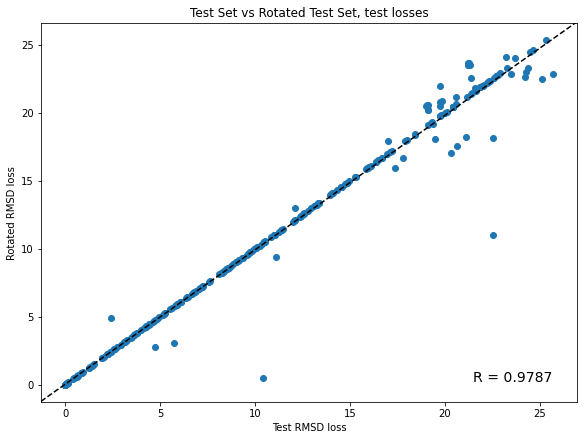

LinregressResult(slope=0.9471720243506062, intercept=1.0403823152746199, rvalue=0.9588585197040369, pvalue=0.0, stderr=0.00852909546986934, intercept_stderr=0.15978752980904776)


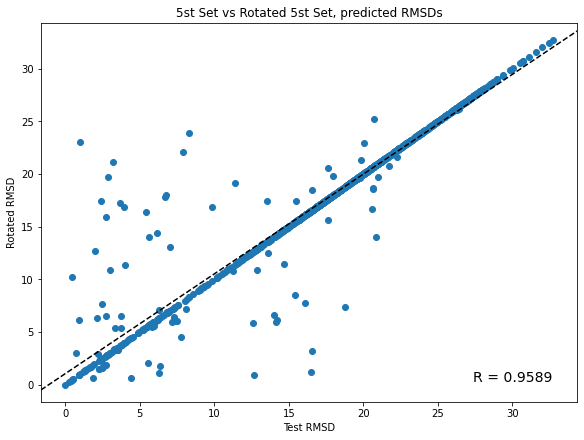

LinregressResult(slope=0.9395366526630656, intercept=0.3544965837011551, rvalue=0.891220447004958, pvalue=0.0, stderr=0.01454321587288265, intercept_stderr=0.08292381621815405)


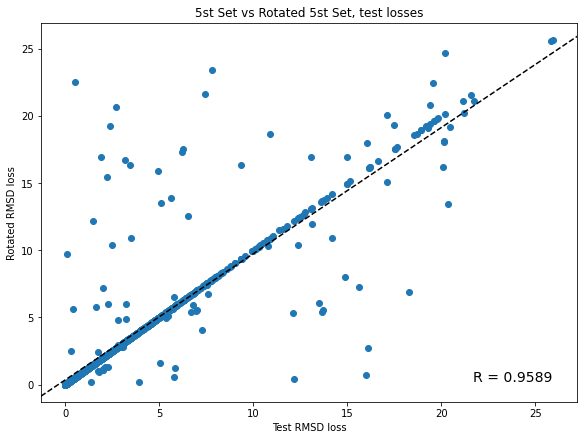

In [8]:
#Test run for rotational invariance
from scipy.stats import linregress
rot_test_dataloader = DataLoader(rot_test_dataset, batch_size=1)
fst_rot_dataloader = DataLoader(fst_rot_dataset, batch_size=1)

def rot_eval(dataloader, rot_dataloader):
    pred_dir = {}
    loss_dir = {}
    for loader in [dataloader, rot_dataloader]:
        with th.no_grad():
            model.eval()
            for test_graph in loader:
                test_graph = test_graph.to(device)
                test_pred, _ = model(test_graph)
                test_loss = F.smooth_l1_loss(test_pred, test_graph.y).item()

                if test_graph.name[0] not in pred_dir.keys():
                    pred_dir[test_graph.name[0]] = [float(test_pred)]
                else:
                    pred_dir[test_graph.name[0]].append(float(test_pred))
                
                if test_graph.name[0] not in loss_dir.keys():
                    loss_dir[test_graph.name[0]] = [float(test_loss)]
                else:
                    loss_dir[test_graph.name[0]].append(float(test_loss))
    return pred_dir, loss_dir

def rot_plot(pred_dir, loss_dir, title):
    test_preds = []
    trot_preds = []
    for a in pred_dir.keys():
        test_preds.append(pred_dir[a][0])
        trot_preds.append(pred_dir[a][1])

    test_ls = []
    trot_ls = []
    for b in loss_dir.keys():
        test_ls.append(loss_dir[b][0])
        trot_ls.append(loss_dir[b][1])

    reg = linregress(test_preds, trot_preds)
    print(reg)

    fig1, axs1 = plt.subplots(layout='constrained', figsize=(8, 6))
    plt.title(title + ", predicted RMSDs")
    axs1.scatter(test_preds, trot_preds)
    axs1.axline(xy1=(0, reg.intercept), slope=reg.slope, linestyle="--", color="k")
    axs1.text(max(test_preds), 0.01, f"R = {reg.rvalue:.4f}", fontsize=14, verticalalignment="bottom", horizontalalignment="right")
    plt.xlabel("Test RMSD")
    plt.ylabel("Rotated RMSD")
    plt.show()

    reg_l = linregress(test_ls, trot_ls)
    print(reg_l)

    fig2, axs2 = plt.subplots(layout='constrained', figsize=(8, 6))
    plt.title(title + ", test losses")
    axs2.scatter(test_ls, trot_ls)
    axs2.axline(xy1=(0, reg_l.intercept), slope=reg_l.slope, linestyle="--", color="k")
    axs2.text(max(test_ls), 0.01, f"R = {reg.rvalue:.4f}", fontsize=14, verticalalignment="bottom", horizontalalignment="right")
    plt.xlabel("Test RMSD loss")
    plt.ylabel("Rotated RMSD loss")
    plt.show()

test_pred_dir, test_loss_dir = rot_eval(test_dataloader, rot_test_dataloader)
rot_plot(test_pred_dir, test_loss_dir, "Test Set vs Rotated Test Set")

fst_pred_dir, fst_loss_dir = rot_eval(st_test_dataloader, fst_rot_dataloader)
rot_plot(fst_pred_dir, fst_loss_dir, "5st Set vs Rotated 5st Set")